In [1]:
# Author: Pongpisit Thanasutives

import lookahead
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams.update({'font.size': 18})

from tqdm import trange

In [2]:
# Create a simple signal with two frequencies
dt = 0.001
t = torch.tensor(np.arange(0,1,dt)).float().requires_grad_(True); n=len(t)
f = torch.sin(2*torch.pi*50*t) + torch.sin(2*torch.pi*120*t) # Sum of 2 frequencies
f_clean = f.detach()
f = f + 2.5*torch.randn(len(t)) # Add some noise

In [3]:
class FFTNN(nn.Module):
    def __init__(self, c=0.0, minmax=(-5.0, 5.0)):
        super(FFTNN, self).__init__()
        self.c = nn.Parameter(data=torch.FloatTensor([c]))
        self.mini = minmax[0]
        self.maxi = minmax[1]
    def forward(self, PSD):
        th = PSD.mean()+torch.clamp(self.c, min=self.mini, max=self.maxi)*PSD.std()
        indices = F.relu(PSD-th)
        d = torch.ones_like(indices)
        d[indices>0] = indices[indices>0]
        indices = indices / d
        return indices

In [4]:
fft = torch.fft.fft(f)
PSD = (1/len(t))*torch.abs(fft)**2

In [5]:
all_losses = []
domain = np.arange(-5.0, 5.1, step=0.1)
for c in domain:
    model = FFTNN(c=c); model.eval()
    all_losses.append(F.mse_loss(torch.fft.ifft(model(PSD)*fft).real, f_clean).item())
print("The best c =", domain[np.argmin(all_losses)])
bc = domain[np.argmin(all_losses)]

The best c = 3.0999999999999712


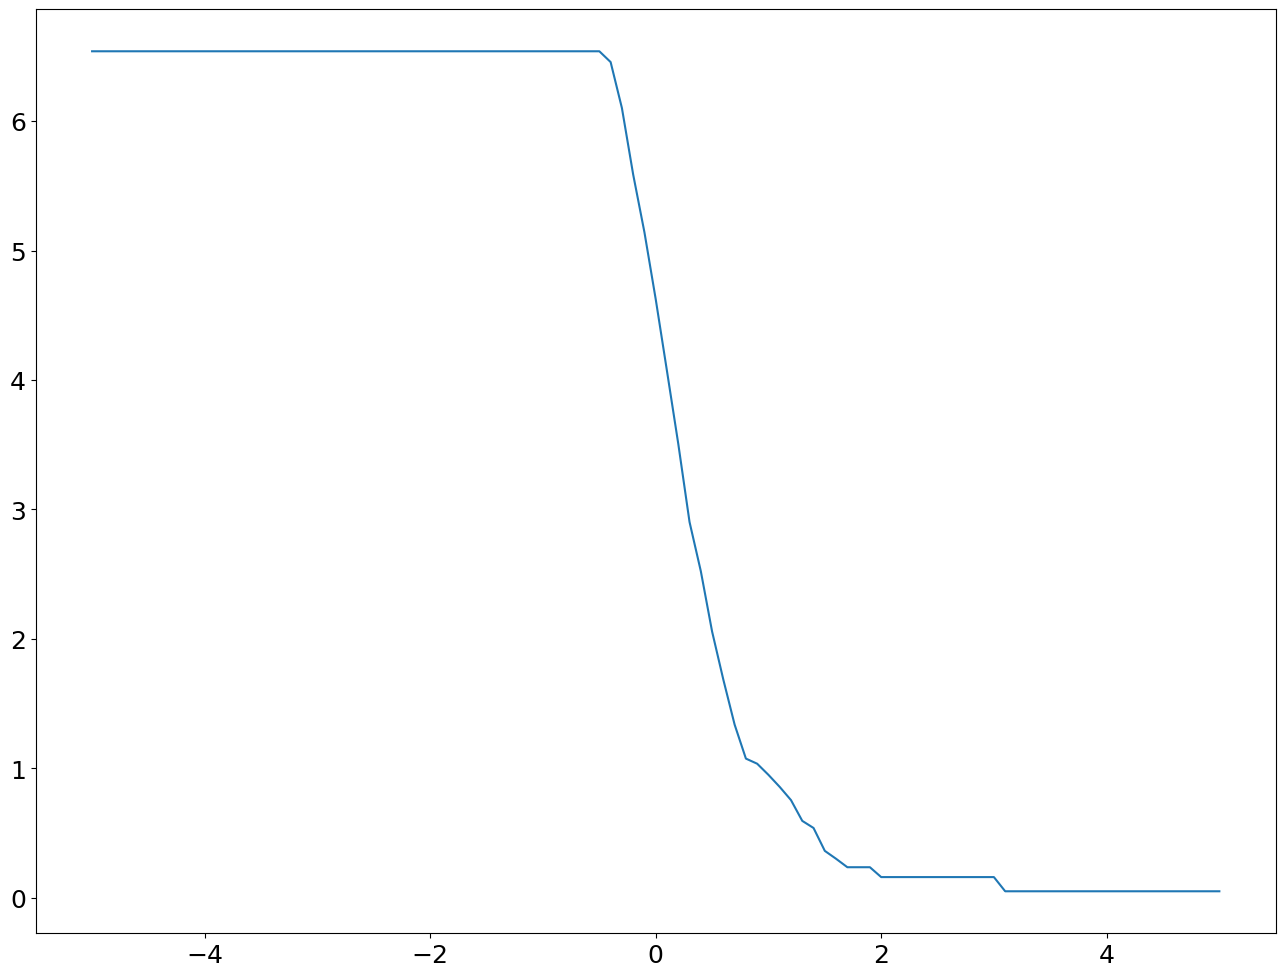

In [6]:
plt.plot(domain, all_losses)
plt.show()

In [7]:
model = FFTNN(c=bc)
out = torch.fft.ifft(model(PSD)*fft).real
F.mse_loss(out, f_clean).item()

0.05035511776804924

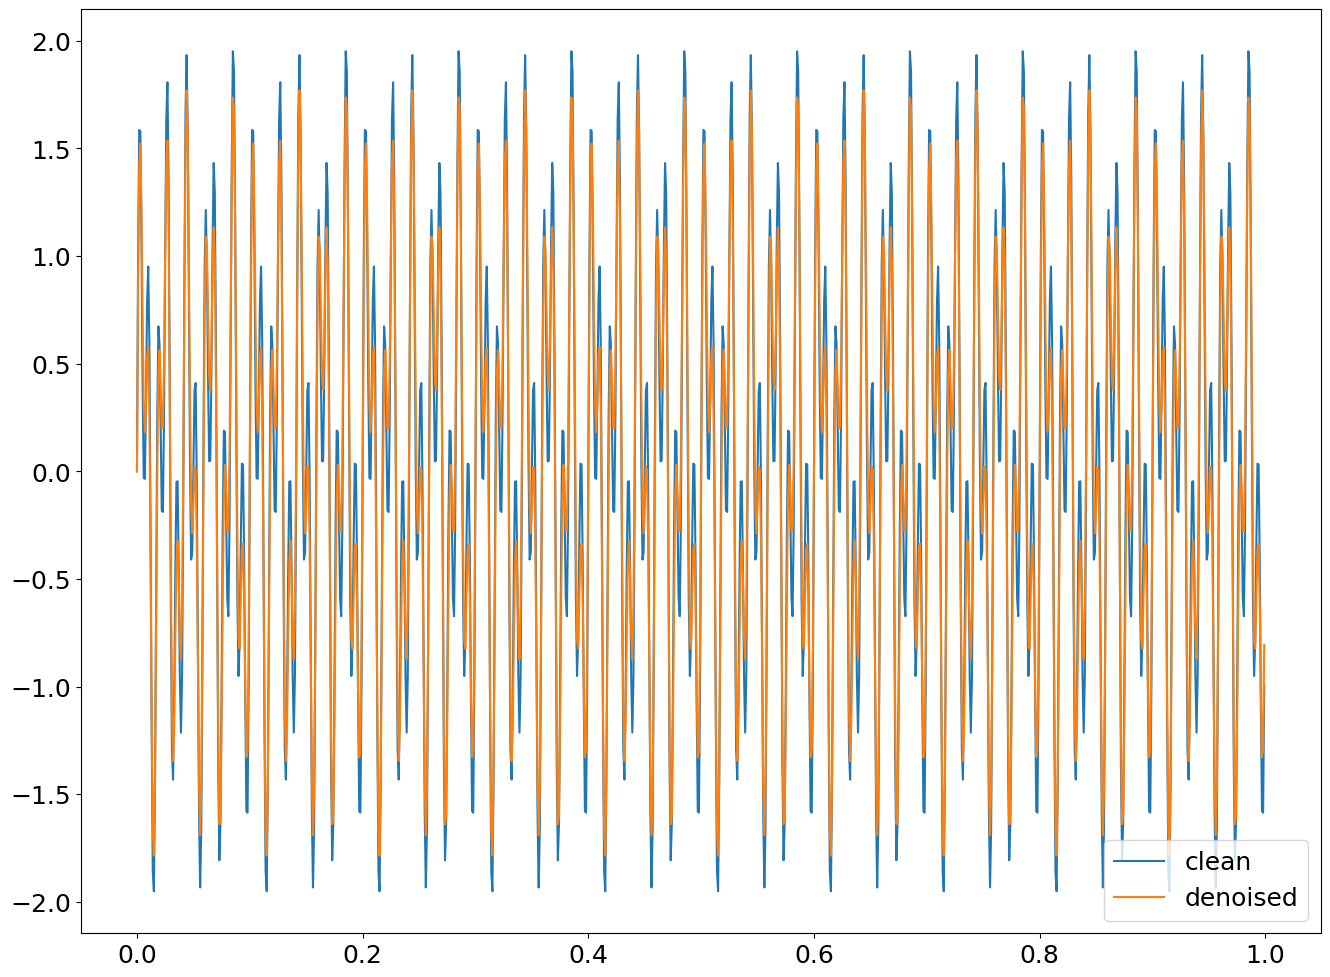

In [8]:
plt.plot(t.detach().numpy(), f_clean.detach().numpy(), label='clean')
plt.plot(t.detach().numpy(), out.detach().numpy(), label='denoised')
plt.legend()
plt.show()